# Imports and Setup


In [1]:
import os, sys, torch, cv2, numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path
import pandas as pd

os.chdir('/Users/devaguru/Kidney Stone CNN/kidney-stone-cnn')
sys.path.insert(0, '.')

from src.evaluation.gradcam import load_model, generate_gradcam

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model  = load_model('checkpoints/best_model.pth', device)
print('Model loaded on:', device)



Model loaded on: mps


# Generate Grad-CAM grid for stone images

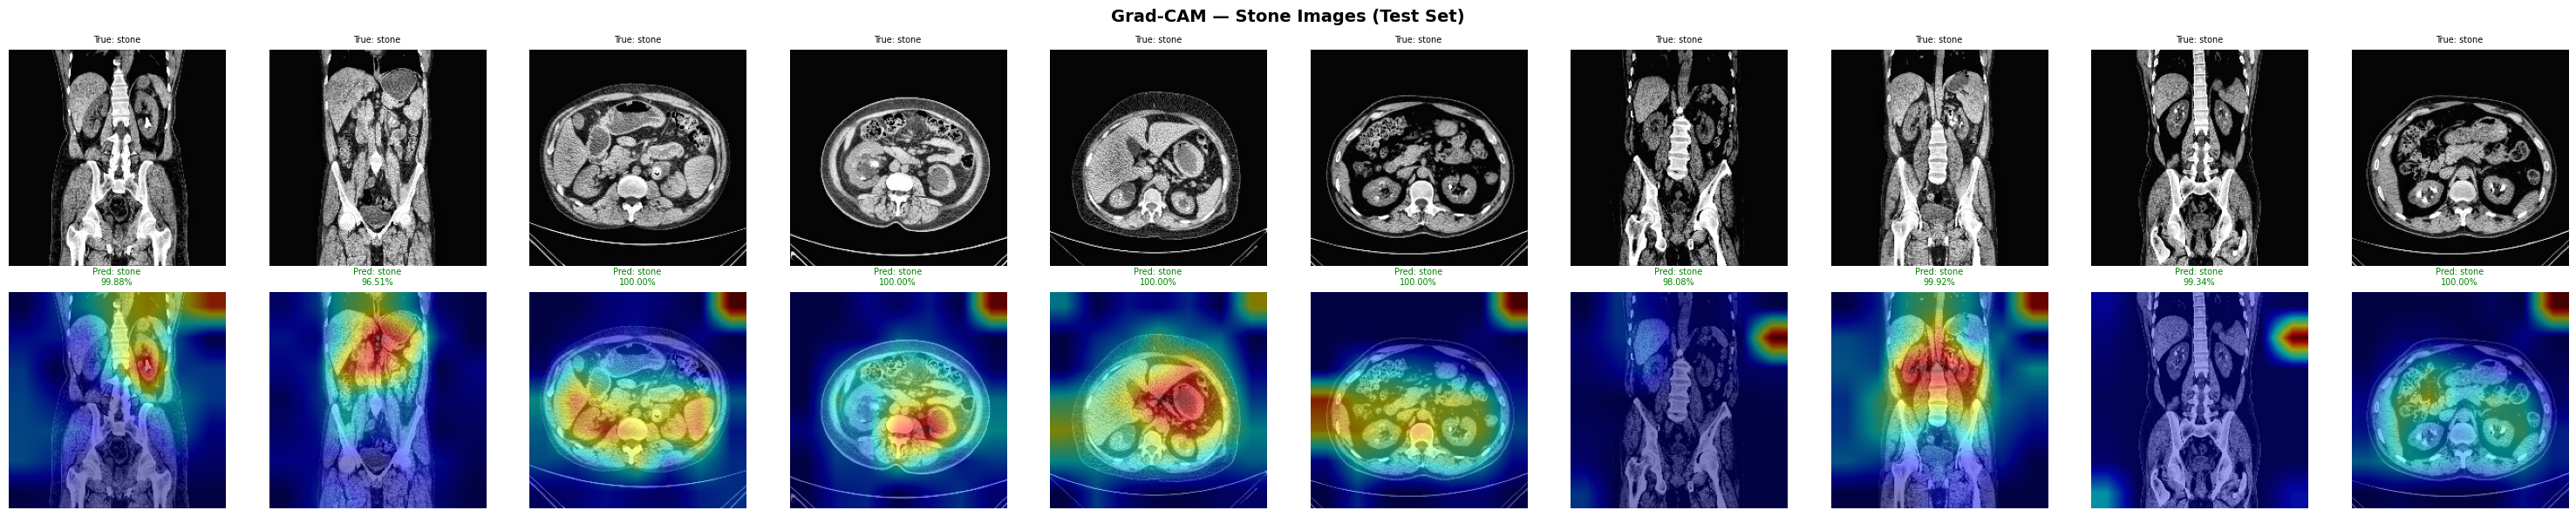

Saved to reports/gradcam_stone.png


In [2]:
df = pd.read_csv('data/labels/splits.csv')
stone_test = df[(df.split=='test') & (df.label=='stone')].head(10)

fig, axes = plt.subplots(2, 10, figsize=(30, 6))
fig.suptitle('Grad-CAM — Stone Images (Test Set)', fontsize=14, fontweight='bold')

for j, (_, row) in enumerate(stone_test.iterrows()):
    img_path = f"data/processed/test/stone/{row['filename']}"
    result   = generate_gradcam(model, img_path, device, target_class=1)

    # Top row: original image
    orig = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    axes[0][j].imshow(orig)
    axes[0][j].set_title(f"True: stone", fontsize=7)
    axes[0][j].axis('off')

    # Bottom row: Grad-CAM overlay
    axes[1][j].imshow(result['overlay'])
    color = 'green' if result['prediction'] == 'stone' else 'red'
    axes[1][j].set_title(
        f"Pred: {result['prediction']}\n{result['confidence']:.2%}",
        fontsize=7, color=color)
    axes[1][j].axis('off')
plt.tight_layout()
plt.savefig('reports/gradcam_stone.png', dpi=120, bbox_inches='tight')
plt.show()
print('Saved to reports/gradcam_stone.png')


# Generate Grad-CAM grid for no-stone images

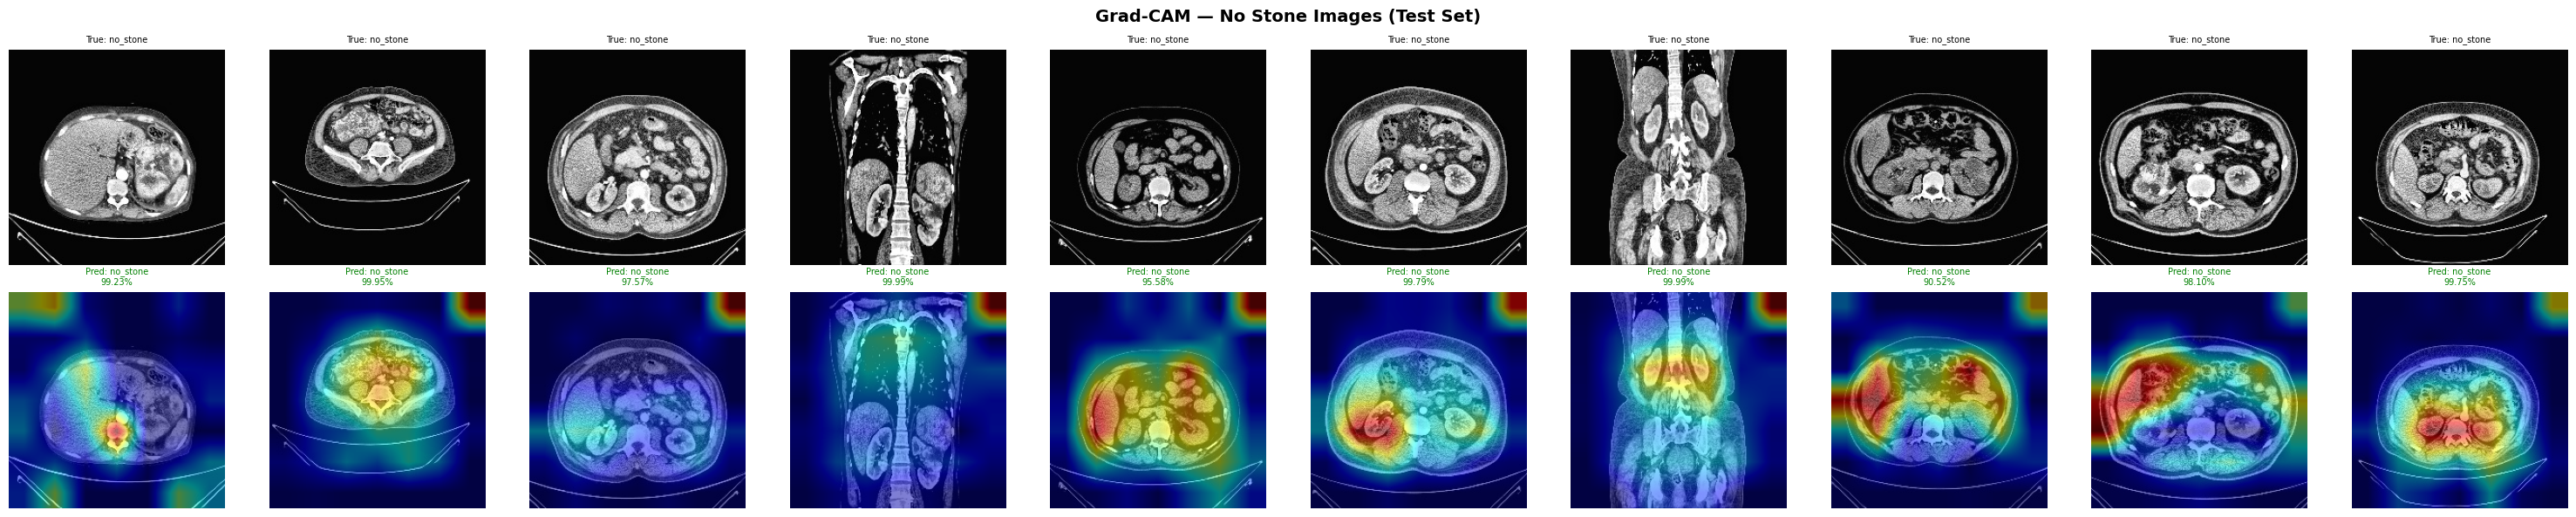

In [3]:
no_stone_test = df[(df.split=='test') & (df.label=='no_stone')].head(10)

fig, axes = plt.subplots(2, 10, figsize=(30, 6))
fig.suptitle('Grad-CAM — No Stone Images (Test Set)', fontsize=14, fontweight='bold')

for j, (_, row) in enumerate(no_stone_test.iterrows()):
    img_path = f"data/processed/test/no_stone/{row['filename']}"
    result   = generate_gradcam(model, img_path, device, target_class=0)

    orig = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    axes[0][j].imshow(orig)
    axes[0][j].set_title('True: no_stone', fontsize=7)
    axes[0][j].axis('off')

    axes[1][j].imshow(result['overlay'])
    color = 'green' if result['prediction'] == 'no_stone' else 'red'
    axes[1][j].set_title(
        f"Pred: {result['prediction']}\n{result['confidence']:.2%}",
        fontsize=7, color=color)
    axes[1][j].axis('off')

plt.tight_layout()
plt.savefig('reports/gradcam_no_stone.png', dpi=120, bbox_inches='tight')
plt.show()


# Error Analysis — Investigate the 14 False Positives

[train] Loaded 8680 images
  stone=952  no_stone=7728
[val] Loaded 1862 images
  stone=201  no_stone=1661
[test] Loaded 1904 images
  stone=224  no_stone=1680
False Positives: 14
False Negatives: 0


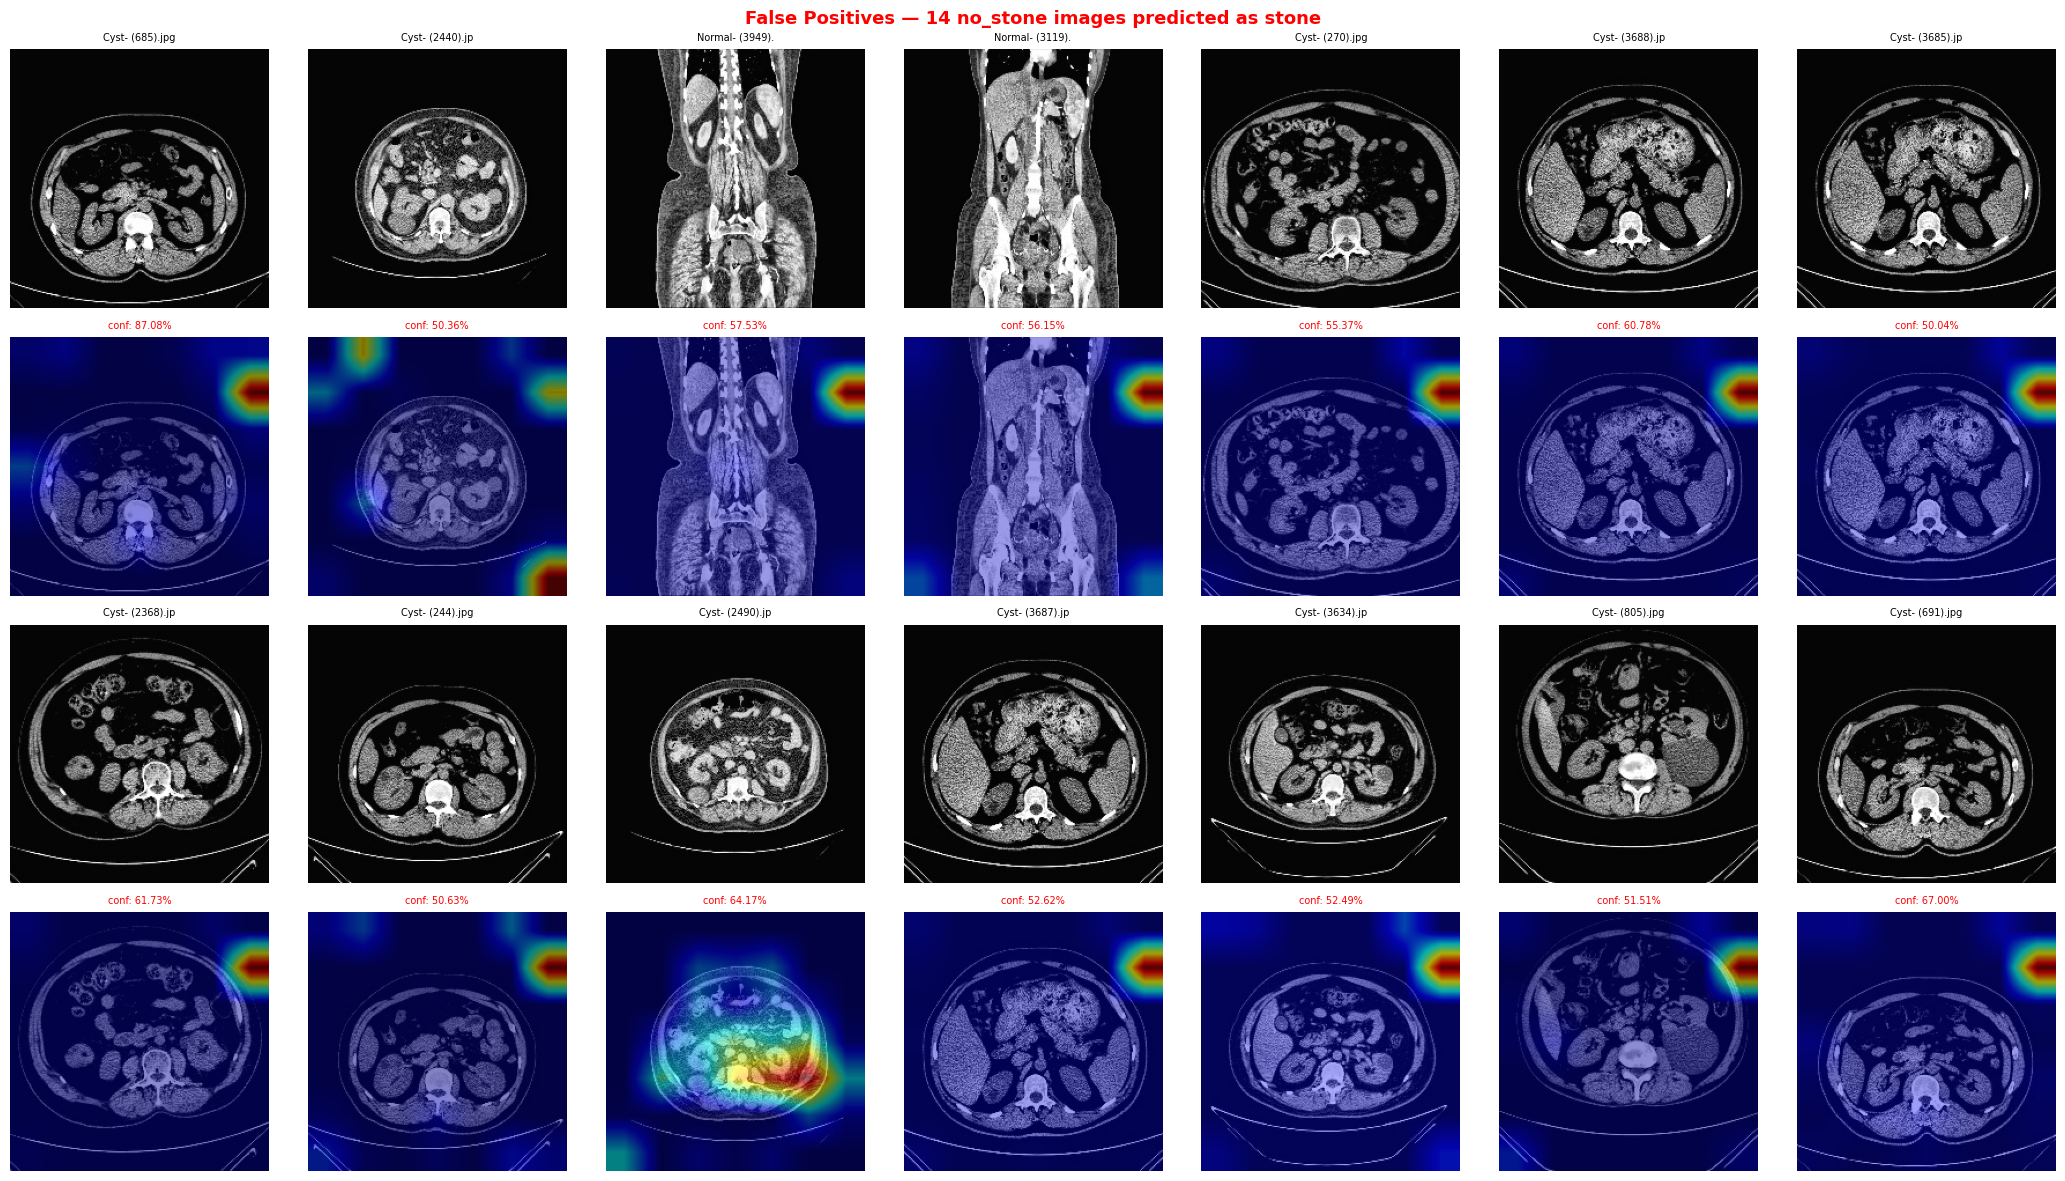

Saved to reports/false_positives.png


In [4]:
import os, sys
os.chdir('/Users/devaguru/Kidney Stone CNN/kidney-stone-cnn')
sys.path.insert(0, '.')
import torch
from src.data.datamodule import KidneyStoneDataModule
from src.models.efficientnet import KidneyStoneClassifier
from src.evaluation.error_analysis import find_errors, plot_false_positives

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model  = KidneyStoneClassifier().to(device)
model.load_state_dict(torch.load('checkpoints/best_model.pth', map_location=device))
model.eval()

dm = KidneyStoneDataModule(batch_size=8, num_workers=0)
dm.setup()

fp, fn, results = find_errors(model, dm, device)
plot_false_positives(fp, model, device, 'reports/false_positives.png')


# Threshold Calibration

[train] Loaded 8680 images
  stone=952  no_stone=7728
[val] Loaded 1862 images
  stone=201  no_stone=1661
[test] Loaded 1904 images
  stone=224  no_stone=1680
Optimal threshold (F2): 0.57
Best F2-score:          0.9960
Use threshold: 0.57 in production


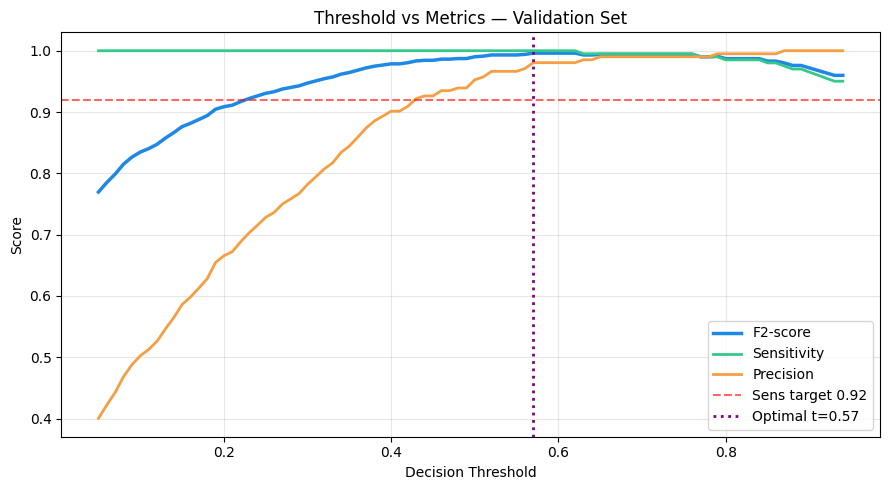

Saved to reports/threshold_curve.png


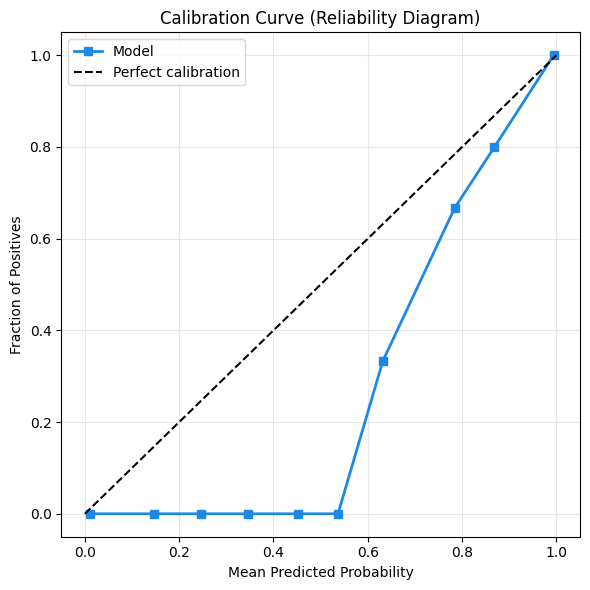

Saved to reports/calibration_curve.png


In [9]:
# Run this in a new notebook cell
import os, sys, torch, numpy as np
os.chdir('/Users/devaguru/Kidney Stone CNN/kidney-stone-cnn')
sys.path.insert(0, '.')
from src.data.datamodule import KidneyStoneDataModule
from src.models.efficientnet import KidneyStoneClassifier
from src.evaluation.calibration import (find_optimal_threshold,
    plot_threshold_curve, plot_calibration_curve)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model  = KidneyStoneClassifier().to(device)
model.load_state_dict(torch.load('checkpoints/best_model.pth', map_location=device))
model.eval()

# Run on VALIDATION set — never tune thresholds on test set
dm = KidneyStoneDataModule(batch_size=8, num_workers=0)
dm.setup()

val_labels, val_probs = [], []
with torch.no_grad():
    for imgs, labels in dm.val_loader():
        probs = torch.softmax(model(imgs.to(device)), dim=1)[:, 1]
        val_labels.extend(labels.numpy())
        val_probs.extend(probs.cpu().numpy())

result = find_optimal_threshold(val_labels, val_probs, beta=2.0)
print(f"Use threshold: {result['threshold']:.2f} in production")

plot_threshold_curve(val_labels, val_probs, 'reports/threshold_curve.png')
plot_calibration_curve(val_labels, val_probs, 'reports/calibration_curve.png')